In [5]:
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import re
import nltk
from wordcloud import WordCloud, STOPWORDS

from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments
)
from peft import PeftModel
from sklearn.feature_extraction.text import CountVectorizer
from textstat import (
    flesch_reading_ease,
    flesch_kincaid_grade,
    difficult_words,
    dale_chall_readability_score
)
from tqdm.notebook import tqdm 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# --- Configuration ---

VALIDATION_DATA_PATH = "./data/text_validation.csv"
MODEL_ARTIFACTS_PATH = "/model/lstm_model"
BASE_MODEL_NAME = "/model/lstm_model"
MAX_LENGTH = 512 
BATCH_SIZE = 16 
OUTPUT_DIR = "/output/error_analysis_output" 

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download stopwords if not already present
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

Using device: cpu


In [7]:
# --- Load Validation Data ---
print(f"\nLoading validation data from: {VALIDATION_DATA_PATH}")
try:
    val_df = pd.read_csv(VALIDATION_DATA_PATH)
    if not {'text', 'label'}.issubset(val_df.columns):
        raise ValueError("CSV must contain 'text' and 'label' columns.")
    # Handle potential NaN/missing text
    val_df['text'] = val_df['text'].fillna('').astype(str)
    print(f"Loaded {len(val_df)} validation samples.")
    print("Label distribution:")
    print(val_df['label'].value_counts())
except FileNotFoundError:
    raise SystemExit(f"Error: Validation data file not found at {VALIDATION_DATA_PATH}")
except Exception as e:
    raise SystemExit(f"Error loading validation data: {e}")


Loading validation data from: ./data/text_validation.csv
Loaded 16000 validation samples.
Label distribution:
label
1    8082
0    7918
Name: count, dtype: int64


In [ ]:
import pandas as pd
from keras.models import load_model
from keras.preprocessing.text import tokenizer_from_json
from keras.utils import pad_sequences
import numpy as np
import json
import os
from data_preprocessing import extract_linguistic_features, minmax_scale_features

VALIDATION_DATA_PATH = "./data/text_validation.csv"
BATCH_SIZE = 16
OUTPUT_DIR = "./output/error_analysis_output"
features_addition = True

val_df = pd.read_csv(VALIDATION_DATA_PATH)

if features_addition:
    print("Linguistic features extraction is enabled.")
    model = load_model("./model/lstm_model_with_features")
else:
    print("Linguistic features extraction is disabled.")
    model = load_model("./model/lstm_model_no_features")
    
with open("./model/tokenizer.json") as f:
    tokenizer_json = f.read()
tokenizer = tokenizer_from_json(tokenizer_json)

print("Model input structure:", model.input)
if features_addition:
    max_length_from_model = model.input[0].shape[1]
else:
    try:
        max_length_from_model = model.input.shape[1]
    except AttributeError:
        raise ValueError("Model input shape is not accessible. Check the loaded model structure.")
    print(f"Model expects input of shape: {max_length_from_model}")

val_sequences = tokenizer.texts_to_sequences(val_df['text'])
val_padded = pad_sequences(val_sequences, maxlen=max_length_from_model, padding='post', truncating='post')


if features_addition:
    print("Linguistic features extraction is enabled.")
    
    features = val_df['text'].apply(extract_linguistic_features)
    features_df = pd.DataFrame(features.tolist())

    print("Linguistic features extracted:")
    print(features_df.head())
    
    scaled_features_df = minmax_scale_features(features_df)
    print("Features scaled using Min-Max scaling:")
    print(scaled_features_df.head())
    
    linguistic_features = scaled_features_df.values
else:
    print("Linguistic features extraction is disabled.")
    linguistic_features = None

if features_addition:
    predicted_probabilities = model.predict(
        [val_padded, linguistic_features], 
        batch_size=BATCH_SIZE
    )
else:
    predicted_probabilities = model.predict(val_padded, batch_size=BATCH_SIZE)

predicted_labels = (predicted_probabilities > 0.5).astype(int).flatten()

val_df['prediction'] = predicted_labels
val_df['pred_probability'] = predicted_probabilities.flatten()
val_df['is_correct'] = (val_df['label'] == val_df['prediction'])

os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, "validation_predictions.csv")
val_df.to_csv(output_path, index=False)

print(f"Validation results saved to {output_path}")

Linguistic features extraction is enabled.
Model input structure: [<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'word_level_input')>, <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'linguistic_input')>]
Linguistic features extraction is enabled.
Linguistic features extracted:
   flesch_reading_ease  flesch_kincaid_grade  smog_index  \
0              -696.55                 300.5         0.0   
1               -59.46                  59.8         0.0   
2               -30.37                  46.6         0.0   
3              -221.87                 116.0         0.0   
4              -283.78                 139.8         0.0   

   dale_chall_readability_score  difficult_words  linsear_write_formula  \
0                         44.35              102                   64.0   
1                         14.66               20                   54.0   
2                         12.27               13                   52.0   
3                         22

In [9]:
# --- Combine Data & Predictions ---
print("\nCombining predictions with original data...")
val_df['prediction'] = predicted_labels
val_df['pred_probability'] = predicted_probabilities
val_df['is_correct'] = (val_df['label'] == val_df['prediction'])

# Identify TP, TN, FP, FN
val_df['result_type'] = 'NA'
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 0), 'result_type'] = 'TN' 
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 1), 'result_type'] = 'TP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 0), 'result_type'] = 'FP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 1), 'result_type'] = 'FN'

print("Prediction results combined. Counts:")
print(val_df['result_type'].value_counts())

# Separate correct and incorrect predictions
correct_df = val_df[val_df['is_correct']].copy()
incorrect_df = val_df[~val_df['is_correct']].copy()
tp_df = val_df[val_df['result_type'] == 'TP'].copy()
tn_df = val_df[val_df['result_type'] == 'TN'].copy()
fp_df = val_df[val_df['result_type'] == 'FP'].copy()
fn_df = val_df[val_df['result_type'] == 'FN'].copy()

if len(incorrect_df) == 0:
    print("\n No misclassifications found on the validation set! Error analysis ends here.")



Combining predictions with original data...
Prediction results combined. Counts:
result_type
TP    7884
TN    4502
FP    3416
FN     198
Name: count, dtype: int64



--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
Correct Predictions:
 count    12386.000000
mean      2129.286937
std       2457.302154
min          5.000000
25%        864.000000
50%       1035.500000
75%       3231.750000
max      39365.000000
Name: text_length, dtype: float64

Incorrect Predictions:
 count     3614.000000
mean      2568.005534
std       3570.882065
min         38.000000
25%        892.000000
50%       1271.500000
75%       3627.000000
max      48723.000000
Name: text_length, dtype: float64


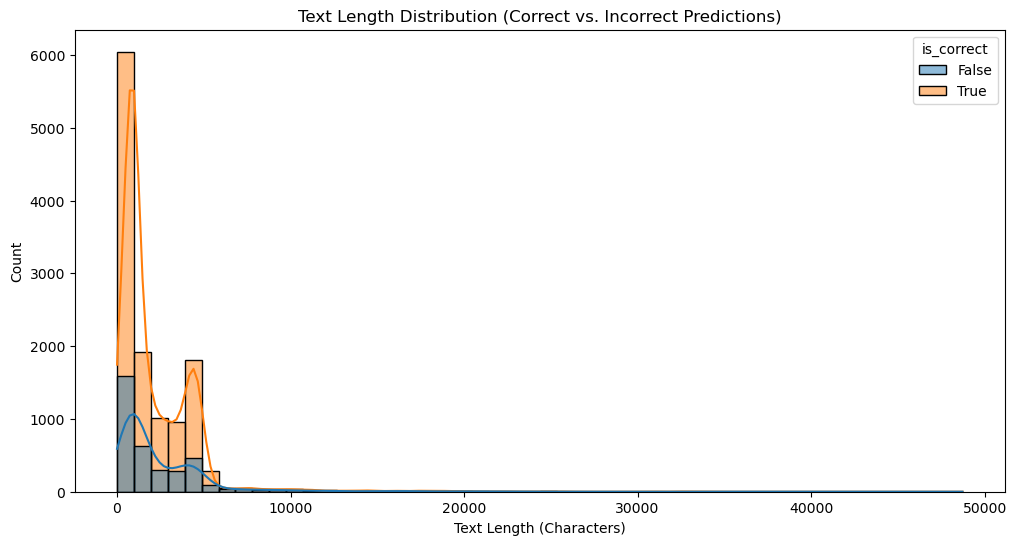

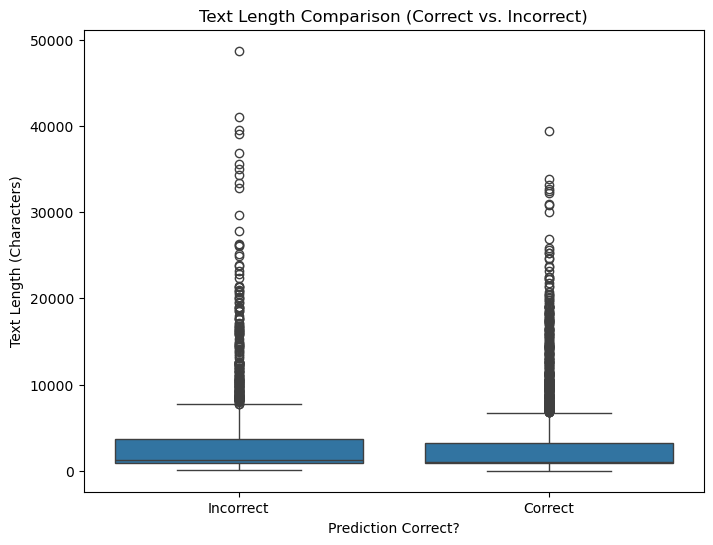

In [10]:
# --- Error Analysis ---

## 1 Text Length Analysis
print("\n--- Analyzing Text Length ---")
val_df['text_length'] = val_df['text'].apply(len)
correct_df['text_length'] = correct_df['text'].apply(len)
incorrect_df['text_length'] = incorrect_df['text'].apply(len)

print("\nDescriptive Statistics for Text Length:")
print("Correct Predictions:\n", correct_df['text_length'].describe())
print("\nIncorrect Predictions:\n", incorrect_df['text_length'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='text_length', hue='is_correct', kde=True, bins=50)
plt.title('Text Length Distribution (Correct vs. Incorrect Predictions)')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Count')
plt.savefig(os.path.join(OUTPUT_DIR, "length_histogram.png"))
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=val_df, x='is_correct', y='text_length')
plt.title('Text Length Comparison (Correct vs. Incorrect)')
plt.xlabel('Prediction Correct?')
plt.ylabel('Text Length (Characters)')
plt.xticks([False, True], ['Incorrect', 'Correct'])
plt.savefig(os.path.join(OUTPUT_DIR, "length_boxplot.png"))
plt.show()


--- Analyzing Text Length by Result Type (TP, TN, FP, FN) ---

--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
TN Predictions:
 count     4502.000000
mean      2171.161484
std       3460.868617
min        325.000000
25%        909.000000
50%        945.500000
75%       1379.500000
max      39365.000000
Name: text_length, dtype: float64

FP Predictions:
 count     3416.000000
mean      2574.860070
std       3654.346514
min         38.000000
25%        890.000000
50%       1215.500000
75%       3609.500000
max      48723.000000
Name: text_length, dtype: float64

TP Predictions:
 count    7884.000000
mean     2105.375317
std      1626.758881
min         5.000000
25%       605.000000
50%      1632.000000
75%      3748.000000
max      5832.000000
Name: text_length, dtype: float64

FN Predictions:
 count     198.000000
mean     2449.747475
std      1532.048520
min       450.000000
25%      1073.250000
50%      2009.000000
75%      3886.500000
max      5322.000000
Name

C:\Users\laihu\AppData\Local\Temp\ipykernel_25892\4212249442.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Result Type')


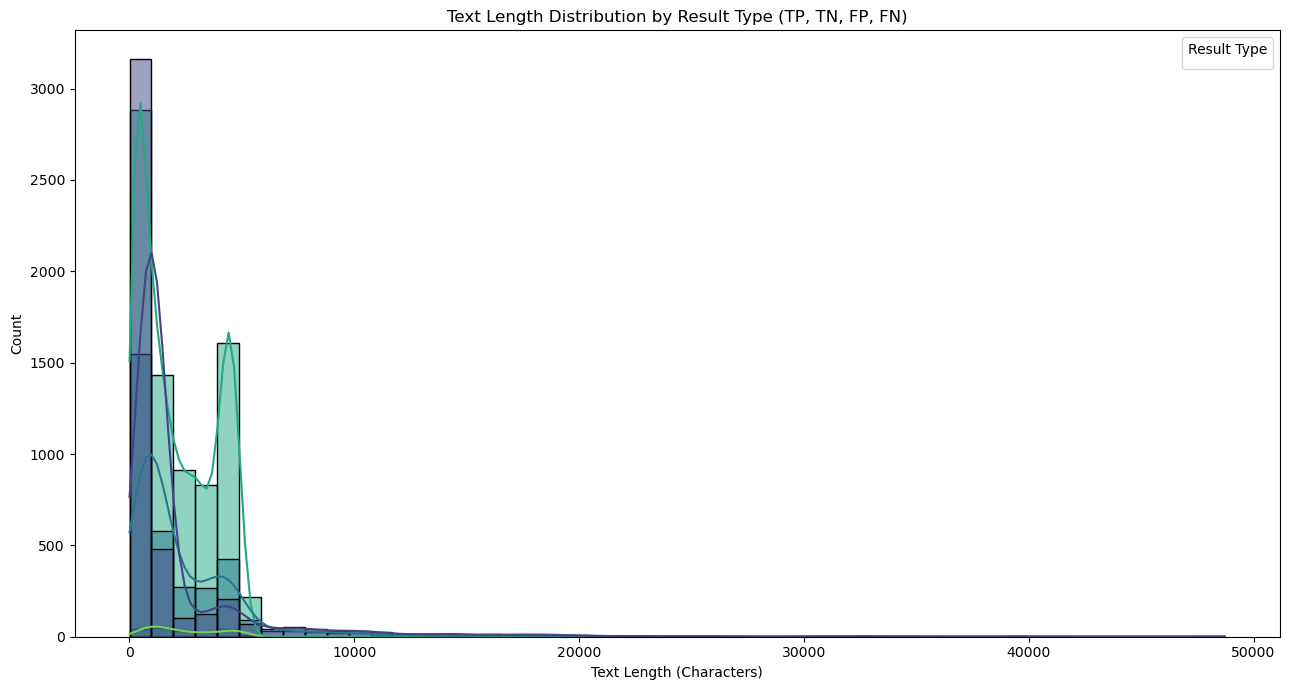

Generating boxplot by result type...


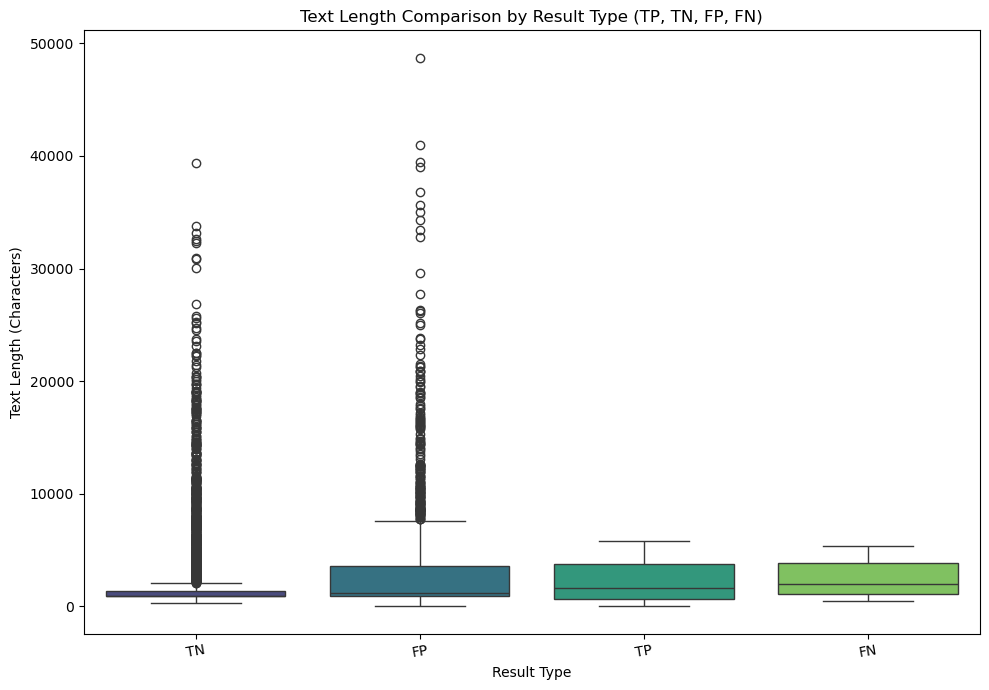

In [11]:
# --- Text Length Analysis by Result Type (TP, TN, FP, FN) ---
print("\n--- Analyzing Text Length by Result Type (TP, TN, FP, FN) ---")

## 1 Text Length Analysis
print("\n--- Analyzing Text Length ---")
tn_df['text_length'] = tn_df['text'].apply(len)
fp_df['text_length'] = fp_df['text'].apply(len)
tp_df['text_length'] = tp_df['text'].apply(len)
fn_df['text_length'] = fn_df['text'].apply(len)

print("\nDescriptive Statistics for Text Length:")
print("TN Predictions:\n", tn_df['text_length'].describe())
print("\nFP Predictions:\n", fp_df['text_length'].describe())
print("\nTP Predictions:\n", tp_df['text_length'].describe())
print("\nFN Predictions:\n", fn_df['text_length'].describe())

# Define the desired order for plot categories
type_order = ['TN', 'FP', 'TP', 'FN']

plot_data = val_df[val_df['result_type'].isin(type_order) & val_df['text_length'].notna()].copy()

if plot_data.empty:
    print("No data found for TP/TN/FP/FN categories. Skipping plots.")
else:
    # 1. Histogram by Result Type
    print("Generating histogram by result type...")
    plt.figure(figsize=(13, 7))
    sns.histplot(data=plot_data, x='text_length', hue='result_type', kde=True, bins=50,
                 hue_order=type_order, palette='viridis')
    plt.title('Text Length Distribution by Result Type (TP, TN, FP, FN)')
    plt.xlabel('Text Length (Characters)')
    plt.ylabel('Count')
    plt.legend(title='Result Type')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "length_histogram_by_type.png"))
    plt.show()

    # 2. Box Plot by Result Type
    print("Generating boxplot by result type...")
    plt.figure(figsize=(10, 7))
    sns.boxplot(data=plot_data, x='result_type', y='text_length',
                order=type_order, palette='viridis')
    plt.title('Text Length Comparison by Result Type (TP, TN, FP, FN)')
    plt.xlabel('Result Type')
    plt.ylabel('Text Length (Characters)')
    plt.xticks(rotation=10) 
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "length_boxplot_by_type.png"))
    plt.show()


- AI vs. Human Length: On average (using the median), AI-generated text (TP) tends to be significantly longer than human-written text (TN) in this dataset. The central 50% of AI text lengths also covers a wider range than human text.
- Outliers: Human text (TN and FP) seems more prone to having extreme length outliers (very long texts) compared to the AI-generated text (TP and FN) in this specific dataset.
- False Positives (FP - Human mistaken for AI): These human texts have a median length somewhat higher than correctly identified human texts (TN) and closer to (but still lower than) AI texts (TP). They also exhibit the long outliers seen in TN. This might suggest that longer human texts are potentially more likely to be misclassified as AI by the model, although length alone isn't the full story.
- False Negatives (FN - AI mistaken for Human): These are rare (n=113). Their median length (1008) is closer to the human median (TN=954) than the AI median (TP=1653). However, their IQR and maximum length are more similar to TP than TN. This suggests that while some FN texts might be shorter (closer to human median), the overall length profile of FNs isn't drastically different from TPs. The reason they are misclassified likely involves factors beyond just raw text length (e.g., style, complexity at a given length).


--- Analyzing Text Complexity ---


Calculating Complexity:   0%|          | 0/16000 [00:00<?, ?it/s]


Average Complexity Scores:
            flesch_ease  flesch_kincaid  difficult_words  dale_chall
is_correct                                                          
False       -368.963096      174.141533        77.287216   29.252933
True        -300.563583      148.279606        61.943969   25.773840


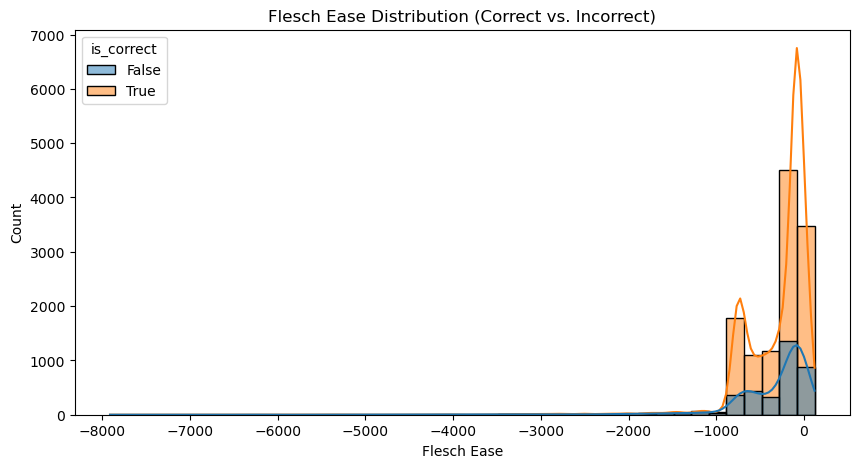

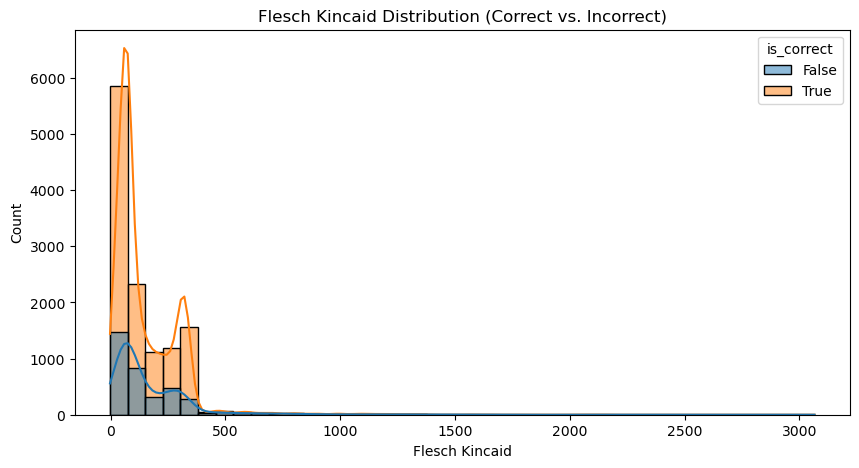

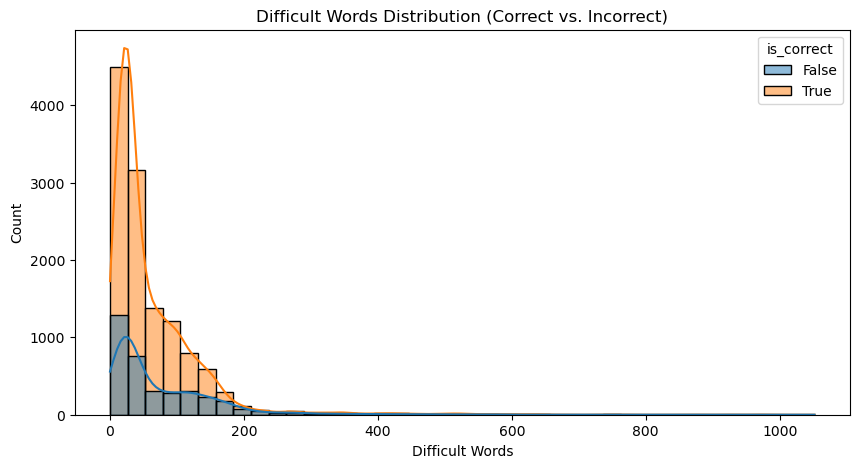

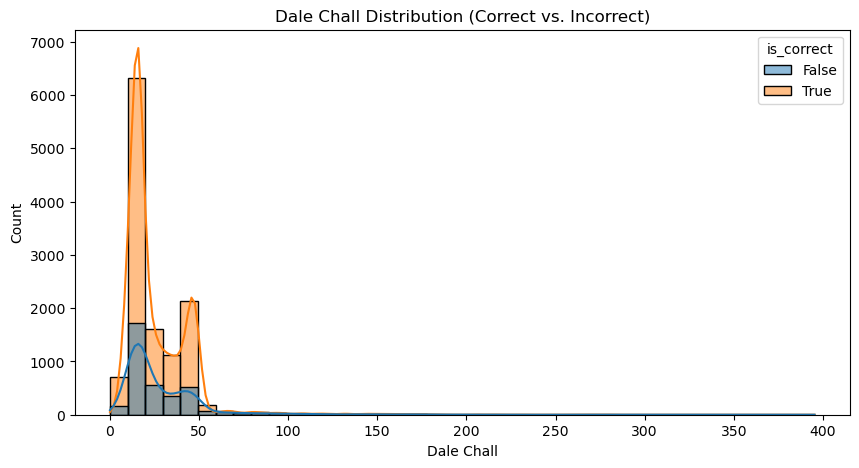

In [12]:
## 2 Text Complexity Analysis 
print("\n--- Analyzing Text Complexity ---")

# Function to calculate all scores
def calculate_complexity(text):
    try:
        return pd.Series({
            'flesch_ease': flesch_reading_ease(text),
            'flesch_kincaid': flesch_kincaid_grade(text),
            'difficult_words': difficult_words(text),
            'dale_chall': dale_chall_readability_score(text)
        })
    except Exception:
        return pd.Series({
            'flesch_ease': np.nan, 'flesch_kincaid': np.nan,
            'difficult_words': np.nan, 'dale_chall': np.nan
        })

# Apply complexity calculations
tqdm.pandas(desc="Calculating Complexity")
complexity_scores = val_df['text'].progress_apply(calculate_complexity)
val_df = pd.concat([val_df, complexity_scores], axis=1)

# Compare average scores
print("\nAverage Complexity Scores:")
print(val_df.groupby('is_correct')[['difficult_words']].mean())

# Plot distributions
complexity_metrics = ['difficult_words']
for metric in complexity_metrics:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=val_df, x=metric, hue='is_correct', kde=True, bins=40)
    plt.title(f'{metric.replace("_", " ").title()} Distribution (Correct vs. Incorrect)')
    plt.xlabel(metric.replace("_", " ").title())
    plt.ylabel('Count')
    plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_hist.png"))
    plt.show()


--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---
Shape before duplicate removal: (16000, 11)
Shape after duplicate removal: (16000, 11)
Columns after duplicate removal: Index(['text', 'label', 'prediction', 'pred_probability', 'is_correct',
       'result_type', 'text_length', 'flesch_ease', 'flesch_kincaid',
       'difficult_words', 'dale_chall'],
      dtype='object')

Descriptive Statistics for Complexity Metrics by Result Type:

--- Flesch Ease ---
              count        mean         std      min      25%      50%  \
result_type                                                              
TN           4502.0 -291.038918  555.449700 -6174.51 -171.960  -92.280   
FP           3416.0 -369.910105  608.199804 -7910.16 -543.960 -146.925   
TP           7884.0 -306.002452  297.437464 -2139.64 -609.260 -217.130   
FN            198.0 -352.624798  265.441285  -812.60 -609.765 -276.680   

                  75%     max  
result_type                    
TN       

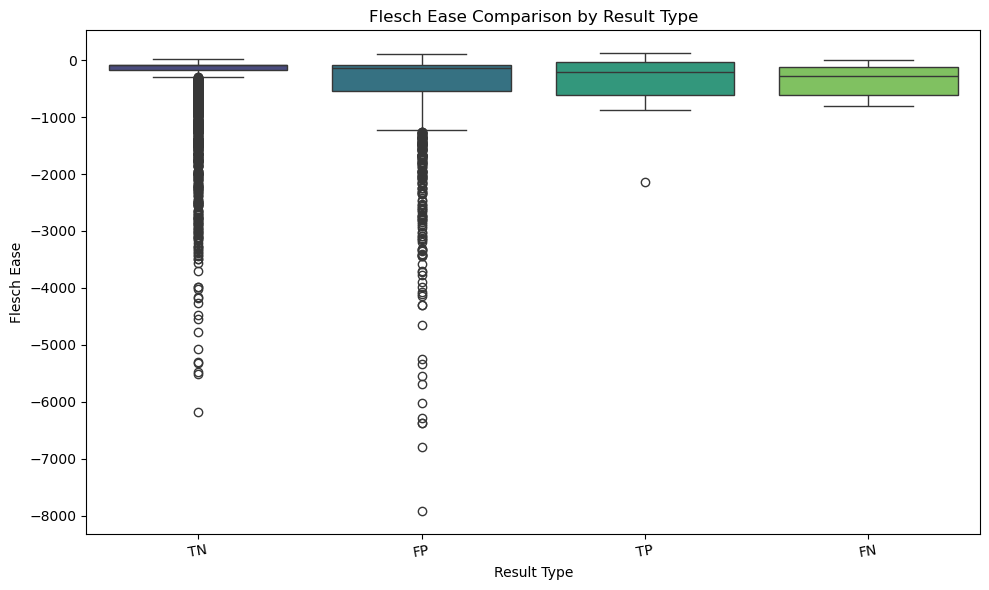

Could not generate legend for flesch_ease histogram.


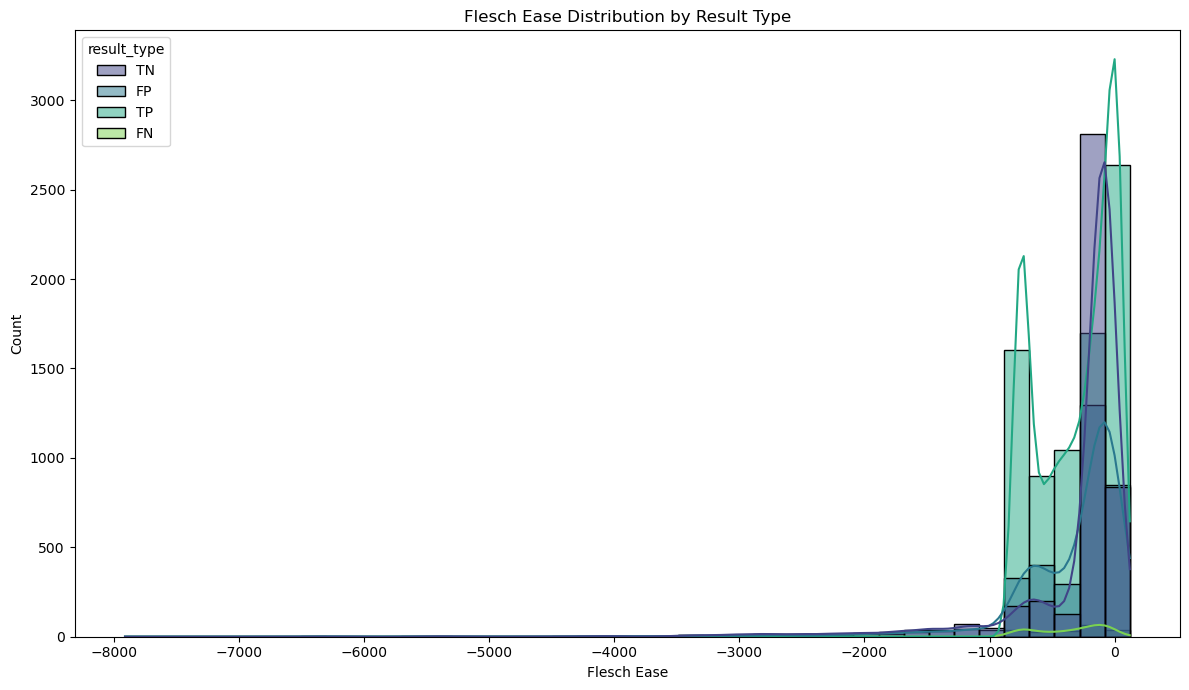

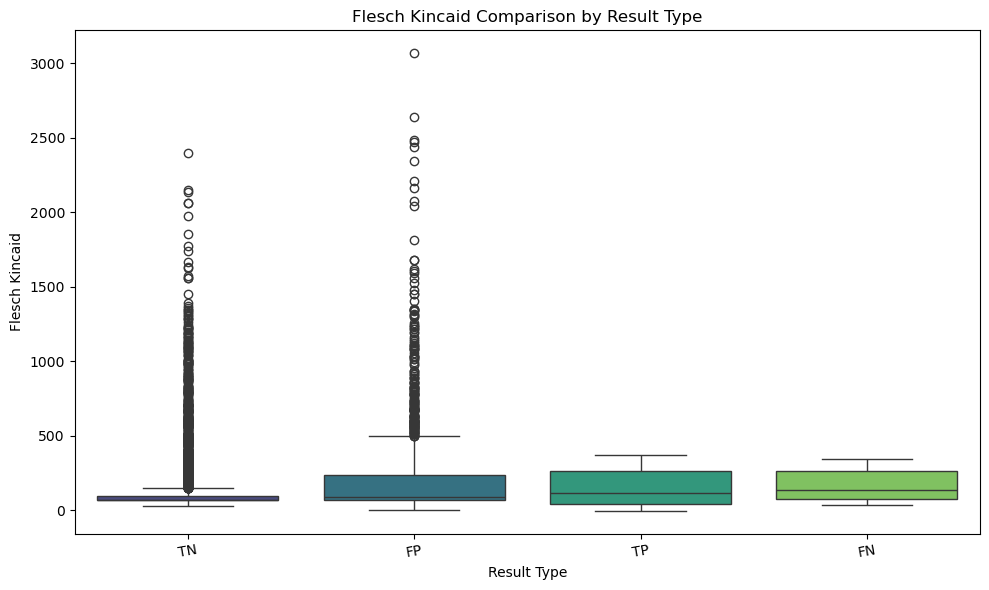

Could not generate legend for flesch_kincaid histogram.


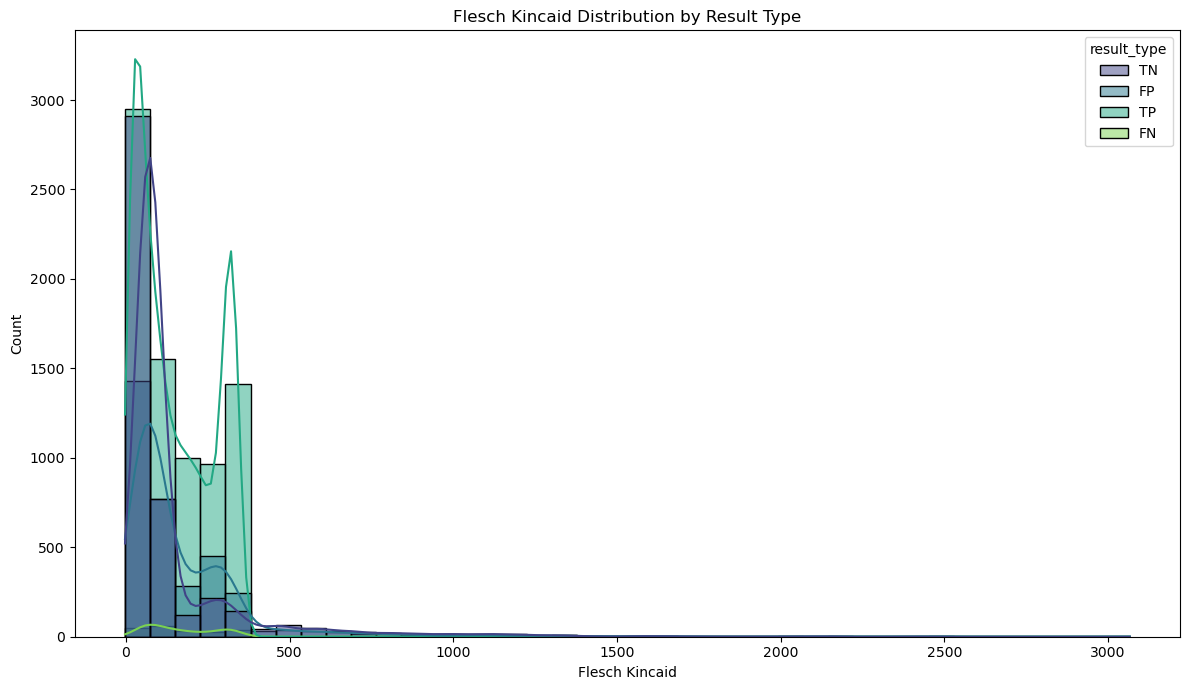

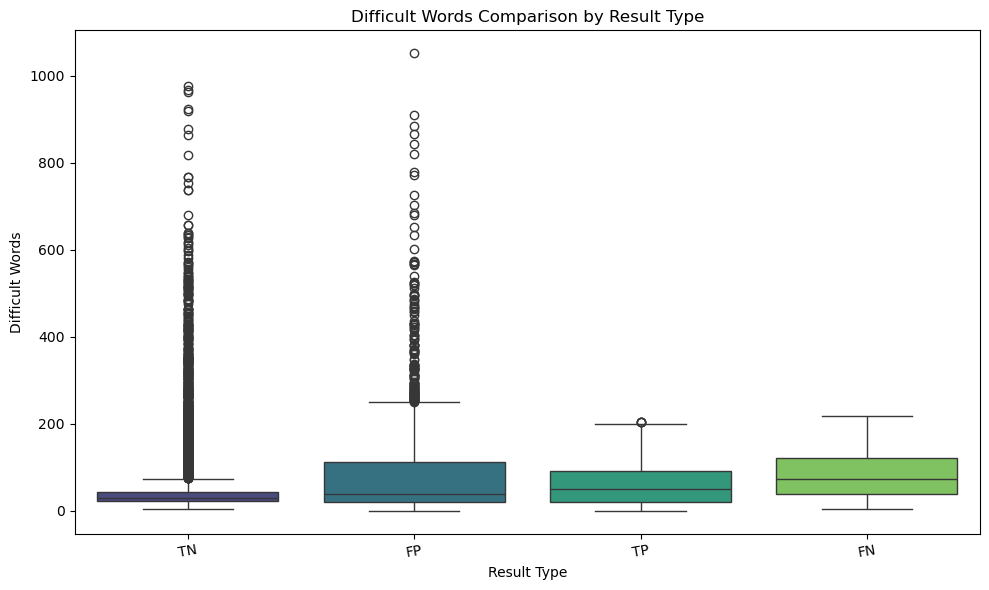

Could not generate legend for difficult_words histogram.


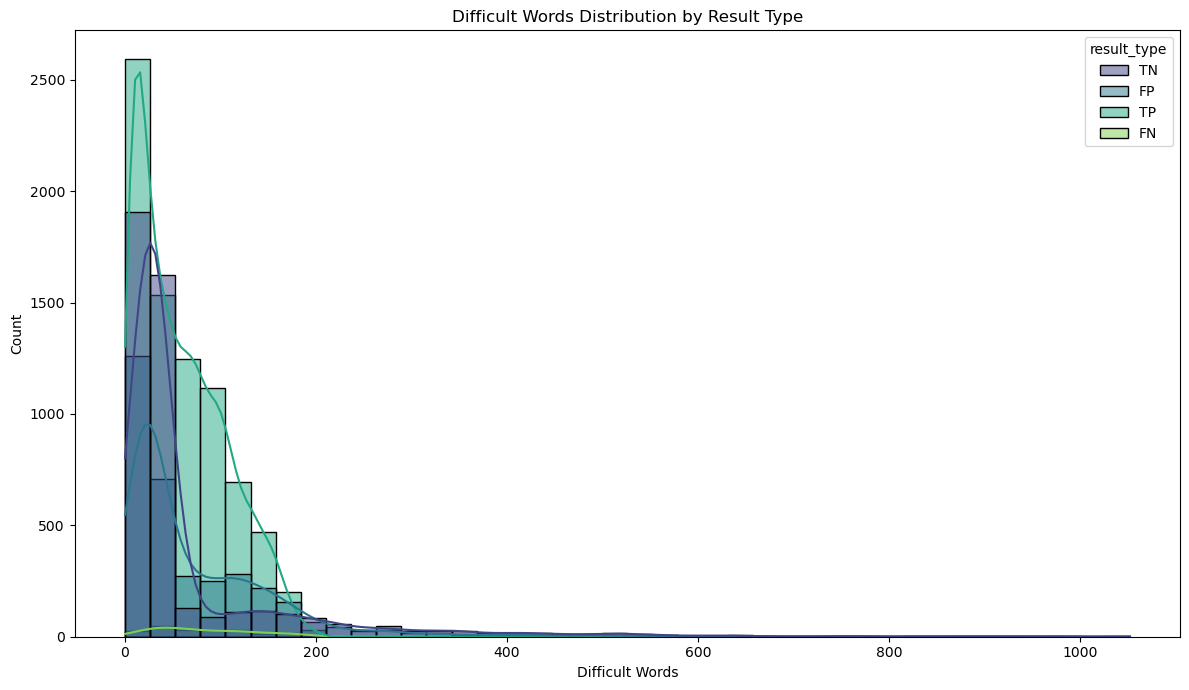

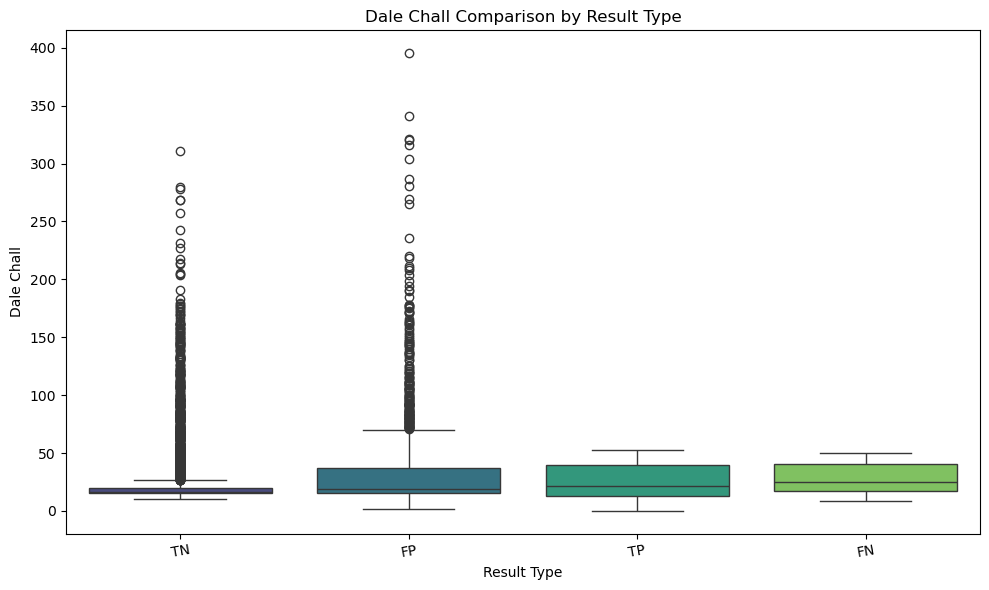

Could not generate legend for dale_chall histogram.


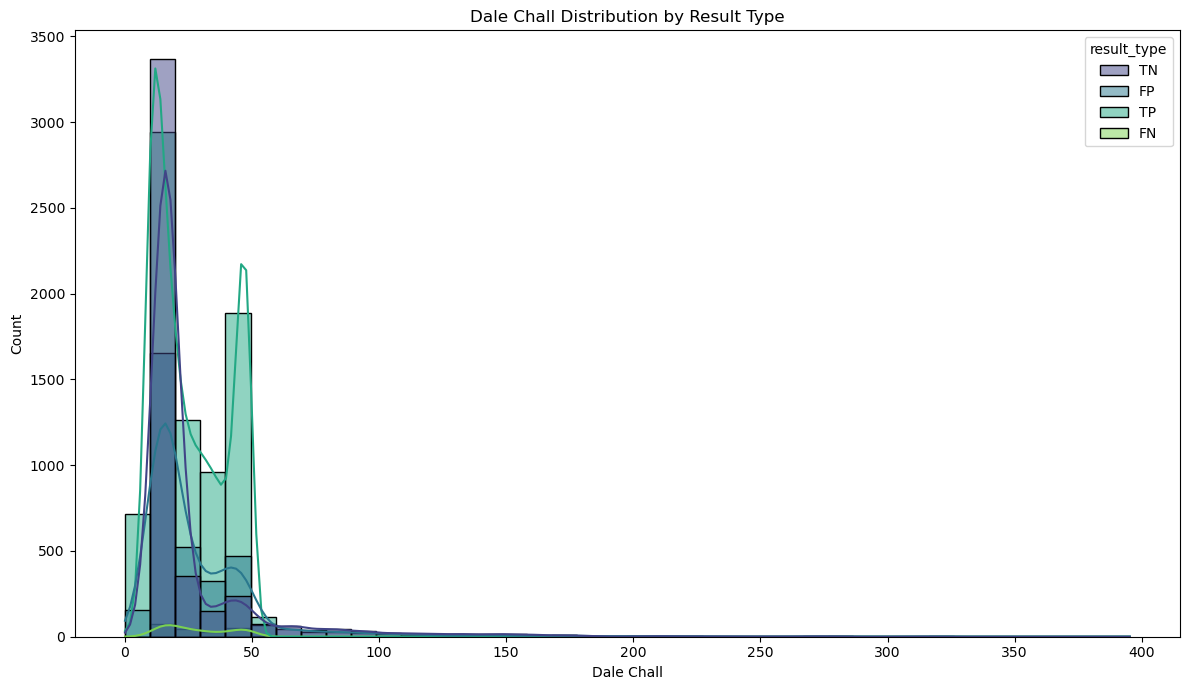

In [13]:
print("\n--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---")

type_order = ['TN', 'FP', 'TP', 'FN']
print("Shape before duplicate removal:", val_df.shape)
val_df = val_df.loc[:, ~val_df.columns.duplicated(keep='first')]
print("Shape after duplicate removal:", val_df.shape)
print("Columns after duplicate removal:", val_df.columns)

plot_data_four_types = val_df[val_df['result_type'].isin(type_order)].copy()

print("\nDescriptive Statistics for Complexity Metrics by Result Type:")
for metric in complexity_metrics:
    if metric in plot_data_four_types.columns:
        print(f"\n--- {metric.replace('_', ' ').title()} ---")
        stats = plot_data_four_types.groupby('result_type')[metric].describe()
        try:
            print(stats.reindex(type_order))
        except KeyError:
            print("Warning: Not all result types found in data for stats ordering.")
            print(stats) 
    else:
        print(f"Metric '{metric}' not found for descriptive stats.")


print("\nGenerating complexity plots by four result types (TN, FP, TP, FN)...")
for metric in complexity_metrics:
    if metric in plot_data_four_types and pd.api.types.is_numeric_dtype(plot_data_four_types[metric]):
       
        plot_data_metric = plot_data_four_types.dropna(subset=[metric, 'result_type'])

        if not plot_data_metric.empty:
            # 1. Box Plot
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=plot_data_metric, x='result_type', y=metric, order=type_order, palette='viridis')
            plt.title(f'{metric.replace("_", " ").title()} Comparison by Result Type')
            plt.xlabel('Result Type')
            plt.ylabel(metric.replace("_", " ").title())
            plt.xticks(rotation=10)
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_boxplot_four_types.png"))
            plt.show()

            # 2. Histogram 
            plt.figure(figsize=(12, 7))
            # Use histplot with hue
            ax = sns.histplot(data=plot_data_metric, x=metric, hue='result_type',
                              hue_order=type_order, kde=True, bins=40, palette='viridis',
                              common_norm=False) 
            plt.title(f'{metric.replace("_", " ").title()} Distribution by Result Type')
            plt.xlabel(metric.replace("_", " ").title())
            plt.ylabel('Count')

            handles, labels = ax.get_legend_handles_labels()
            if handles and labels:
                 ax.legend(handles=handles, labels=labels, title='Result Type', bbox_to_anchor=(1.02, 1), loc='upper left')
                 plt.subplots_adjust(right=0.85) 
            else:
                 print(f"Could not generate legend for {metric} histogram.")
                 plt.tight_layout() 

            plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_hist_four_types.png"))
            plt.show()
        else:
            print(f"No valid data to plot for {metric} across four types after dropping NaNs.")
    else:
        print(f"Skipping plots for {metric} as column is missing or not numeric in filtered data.")


- False Negatives (FN) are Consistently Simpler: The strongest pattern is that texts incorrectly classified as negative (FNs) are consistently measured as being less complex across all four metrics compared to texts correctly classified as positive (TPs). This suggests the model may be associating higher complexity with the positive class and struggles to identify positive instances when the text is relatively simpler.

- False Positives (FP) also Tend Towards Simplicity: Texts incorrectly classified as positive (FPs) also tend to show lower complexity scores (easier to read, lower grade level, fewer difficult words on average) compared to the average True Negative (TN), although the comparison is muddied by the extreme variability within TNs. They appear more complex than FNs but less complex than TPs based on medians.

- True Positives (TP) are Consistently More Complex (Median): TPs generally show higher median complexity scores across FKGL, Difficult Words, and Dale-Chall, and the lowest median Flesch Ease.
- True Negatives (TN) are Highly Variable: This group exhibits the most extreme range and standard deviation in complexity scores, likely containing a mix of simple texts and some very complex outliers.

- Text complexity appears to be a factor influencing the model's errors. The model might be implicitly using complexity as a feature, leading it to:
1. Miss simpler positive cases (FNs)
2. Incorrectly flag simpler negative cases as positive (FPs).


--- Analyzing Top Keywords ---

Top 20 Keywords for Correct Predictions:
   Keyword  Frequency
0     said      12528
1   people      10738
2      new      10525
3     time       8488
4     like       8043
5     just       8005
6     make       6469
7      way       5329
8      use       5128
9     know       4846
10   years       4580
11   world       4518
12    want       4405
13    dont       4367
14   going       4345
15    good       4316
16    work       4124
17   think       4096
18    need       4080
19    year       3772


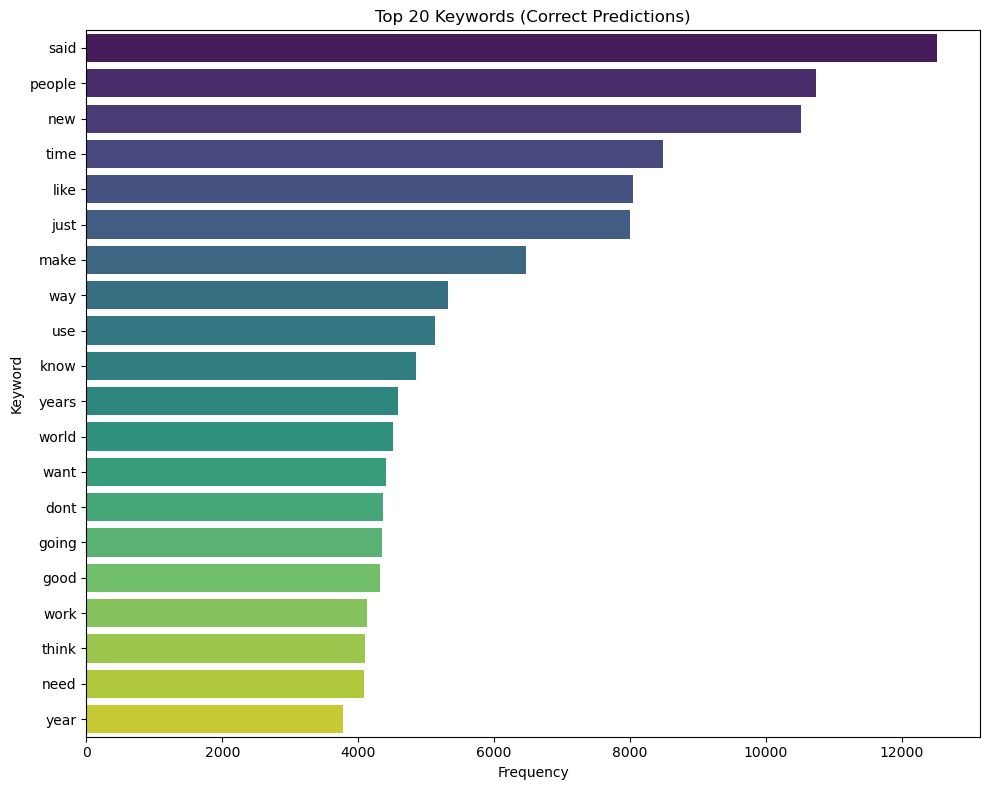


Top 20 Keywords for Incorrect Predictions:
      Keyword  Frequency
0      people       3531
1        said       2929
2        time       2734
3         new       2678
4        like       2537
5        just       2331
6         use       1749
7       world       1652
8        make       1647
9         way       1542
10      years       1477
11       used       1412
12    company       1373
13       know       1371
14       life       1371
15       work       1323
16  different       1293
17       good       1190
18       year       1145
19       dont       1122


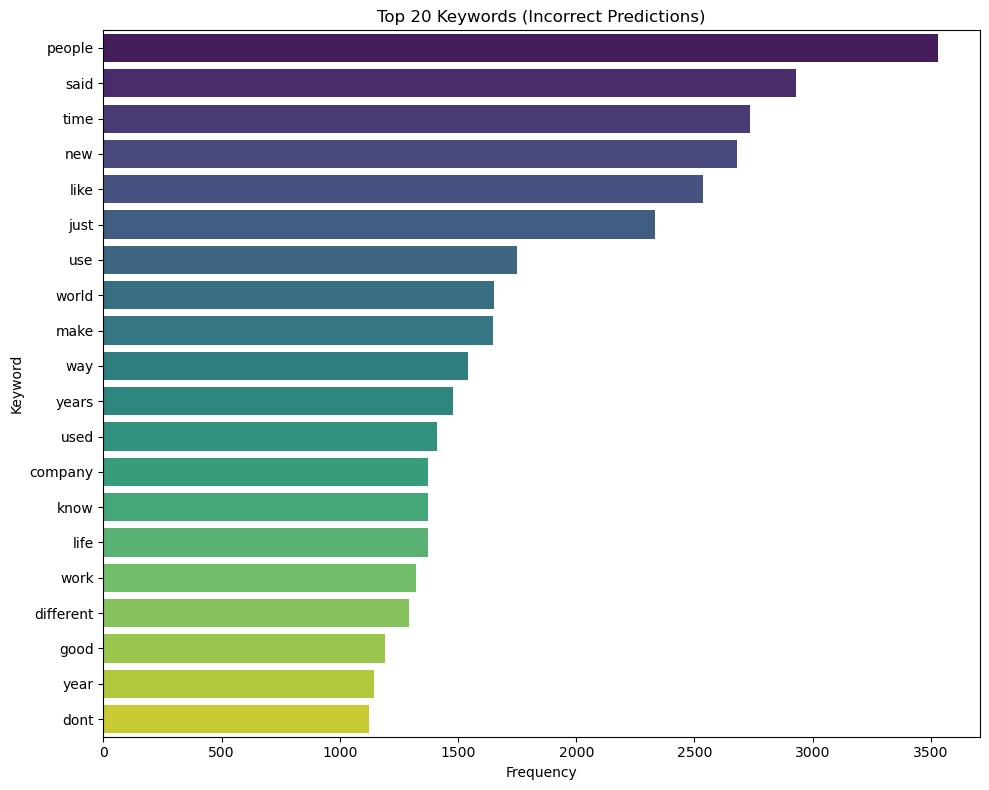

In [14]:
## 3 Keyword Analysis 
print("\n--- Analyzing Top Keywords ---")

def plot_top_keywords(df, text_column, title_suffix, num_keywords=20, filename_suffix=""):
    if len(df) == 0:
        print(f"Skipping keyword analysis for '{title_suffix}': No samples.")
        return

    print(f"\nTop {num_keywords} Keywords for {title_suffix}:")
    try:
        vec = CountVectorizer(stop_words='english', max_features=num_keywords).fit(df[text_column])
        bag_of_words = vec.transform(df[text_column])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

        top_df = pd.DataFrame(words_freq[:num_keywords], columns=['Keyword', 'Frequency'])
        print(top_df)

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')
        plt.title(f'Top {num_keywords} Keywords ({title_suffix})')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"keywords_{filename_suffix}.png"))
        plt.show()

    except ValueError as e:
        print(f"Could not generate keywords for {title_suffix}: {e}") 

# Compare Correct vs Incorrect
plot_top_keywords(correct_df, 'text', 'Correct Predictions', filename_suffix="correct")
plot_top_keywords(incorrect_df, 'text', 'Incorrect Predictions', filename_suffix="incorrect")

# analyze FP and FN separately
# plot_top_keywords(fp_df, 'text', 'False Positives (Human -> AI)', filename_suffix="fp")
# plot_top_keywords(fn_df, 'text', 'False Negatives (AI -> Human)', filename_suffix="fn")



Top 20 Keywords for True Negatives (Human):
       Keyword  Frequency
0         time       2920
1       people       2911
2         like       2699
3         just       2547
4          new       2235
5         said       1928
6      company       1799
7        world       1709
8          way       1699
9         life       1593
10        work       1495
11         use       1470
12        know       1461
13         man       1436
14    business       1382
15  management       1375
16       human       1366
17       years       1357
18         did       1327
19        make       1308


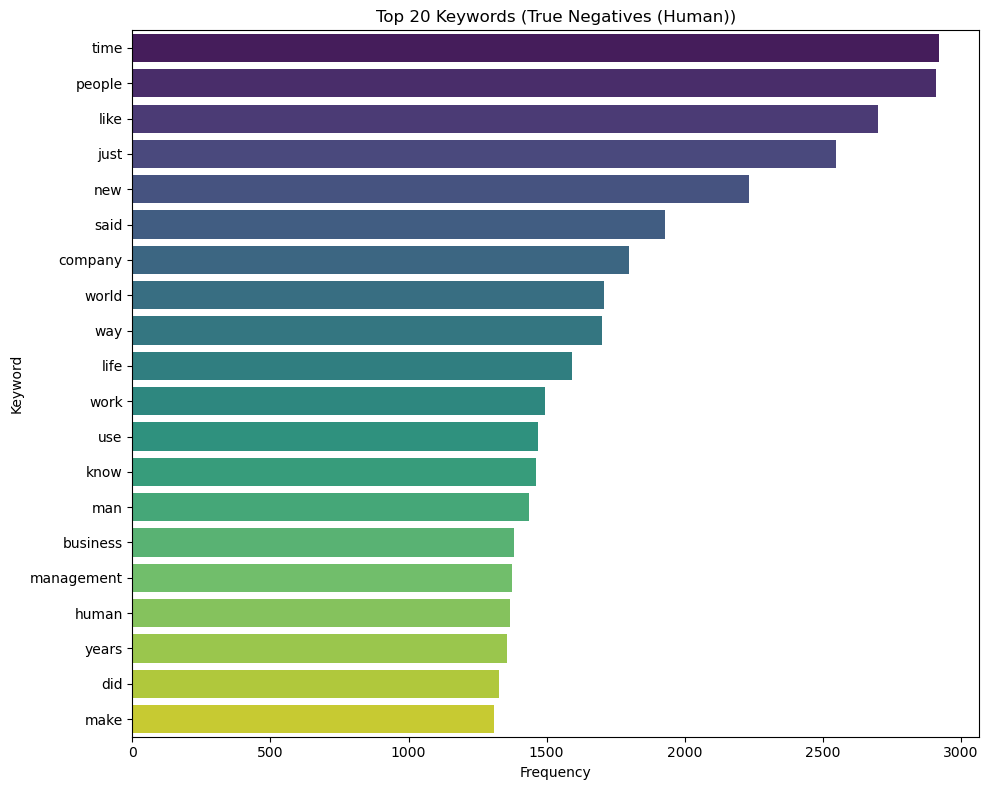


Top 20 Keywords for False Positives (Human -> AI):
      Keyword  Frequency
0      people       3378
1        said       2652
2        time       2641
3        like       2439
4         new       2437
5        just       2229
6         use       1627
7       world       1565
8        make       1563
9         way       1469
10      years       1385
11       life       1325
12    company       1320
13       used       1320
14       know       1315
15       work       1275
16  different       1256
17       good       1155
18       year       1088
19       need       1071


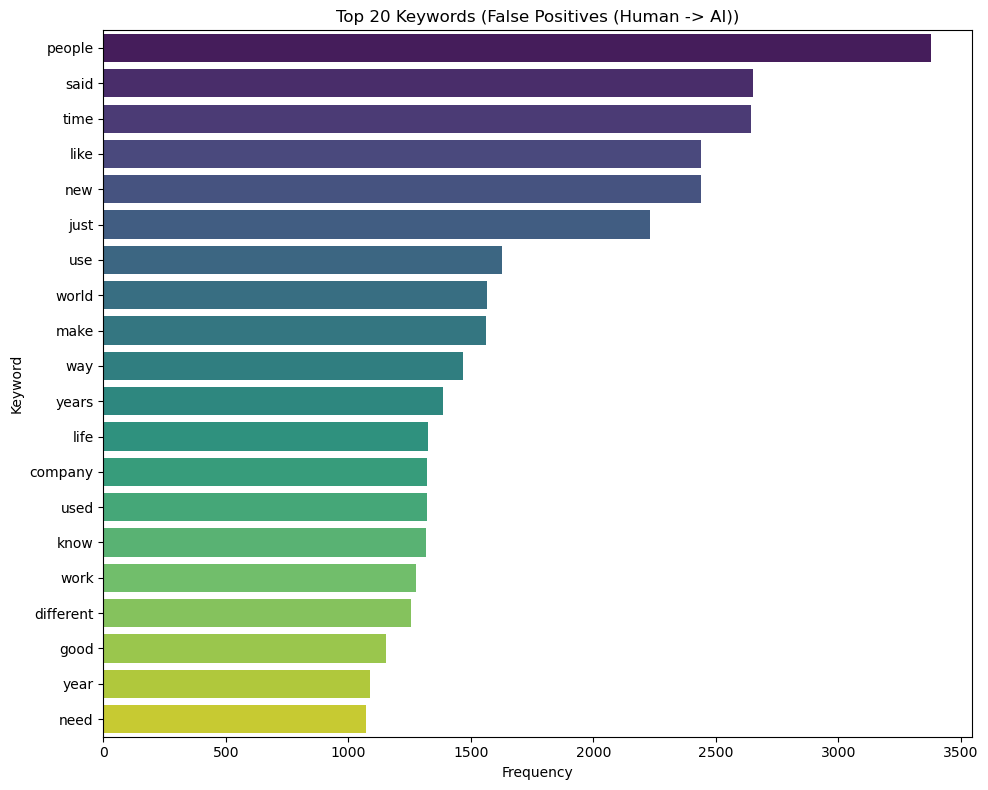


Top 20 Keywords for False Negatives (AI -> Human):
        Keyword  Frequency
0          said        277
1           new        241
2        people        153
3           use        122
4          just        102
5          like         98
6          time         93
7          used         92
8         years         92
9         state         90
10   government         89
11        world         87
12       police         86
13  information         84
14         make         84
15       states         76
16      chinese         74
17          way         73
18        human         72
19       public         72


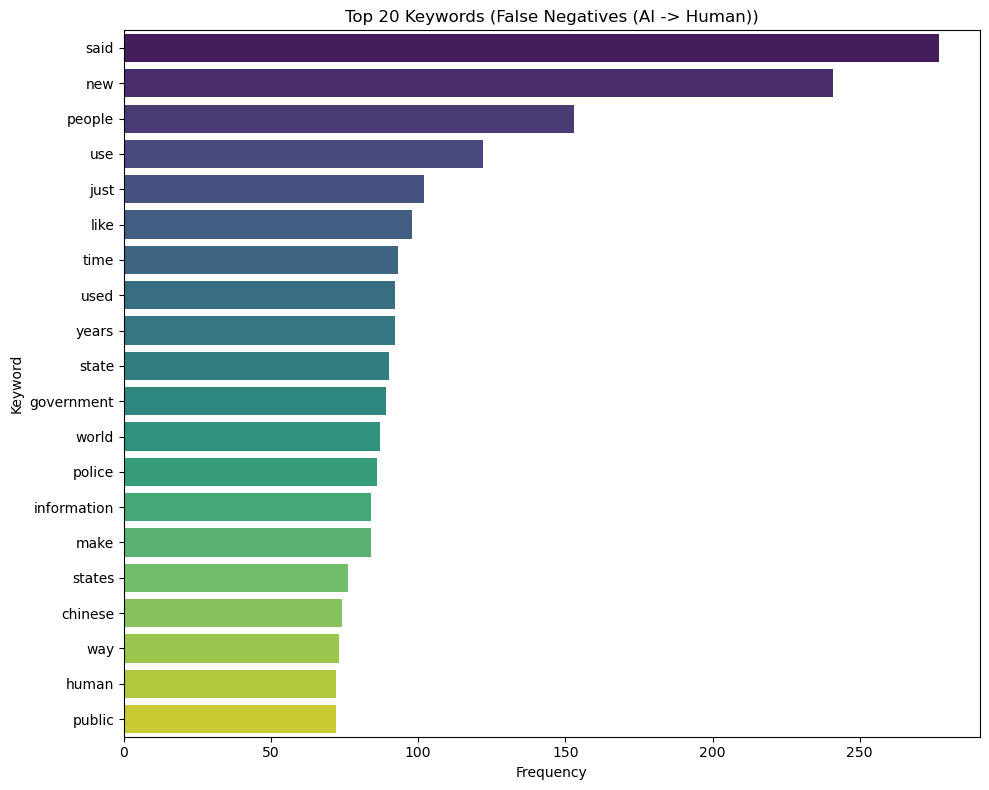


Top 20 Keywords for True Positives (AI):
       Keyword  Frequency
0         said      10600
1          new       8290
2       people       7827
3         time       5568
4         just       5458
5         like       5344
6         make       5161
7         want       3740
8          use       3658
9          way       3630
10        dont       3474
11       going       3470
12        know       3385
13        good       3232
14       think       3231
15       years       3223
16        year       3080
17        game       3064
18        need       2987
19  government       2899


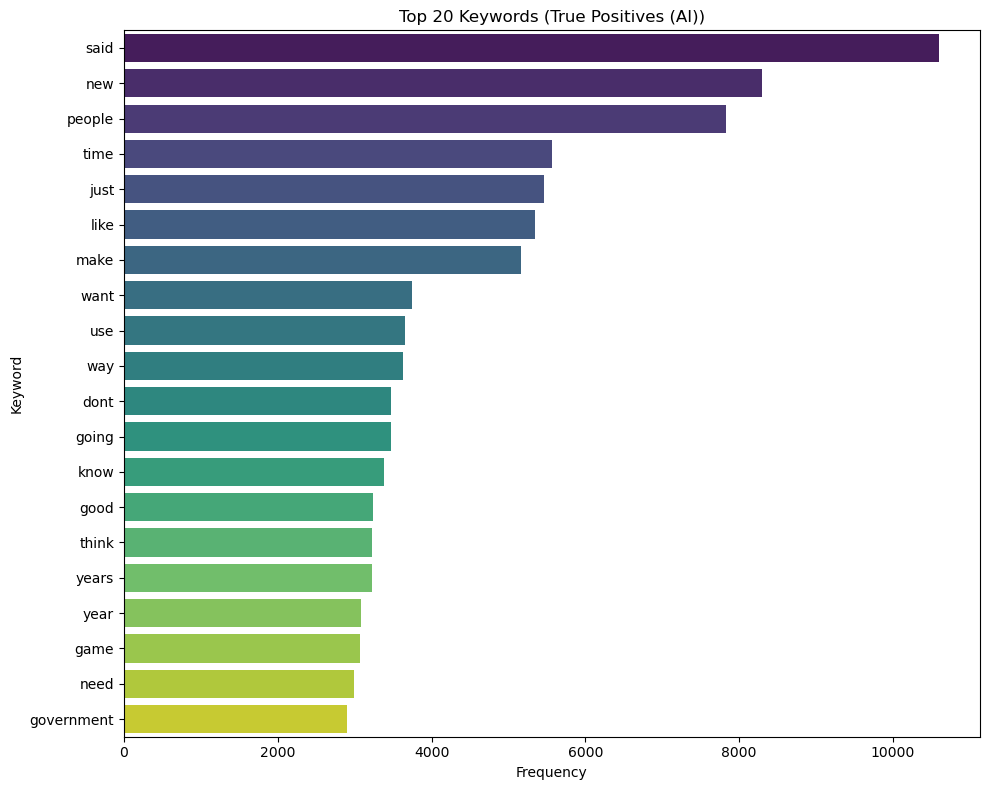

In [15]:
plot_top_keywords(tn_df, 'text', 'True Negatives (Human)', filename_suffix="tn")
plot_top_keywords(fp_df, 'text', 'False Positives (Human -> AI)', filename_suffix="fp")
plot_top_keywords(fn_df, 'text', 'False Negatives (AI -> Human)', filename_suffix="fn")
plot_top_keywords(tp_df, 'text', 'True Positives (AI)', filename_suffix="tp")


--- Analyzing N-grams ---

-- Top 2-grams --

Top 2-grams for Correct Predictions:
      2-gram  Frequency
0     of the      31025
1     in the      26582
2     to the      13457
3     on the      10849
4    and the       8749
5      to be       8610
6    for the       8170
7   that the       7620
8       in a       6954
9   with the       6481
10    at the       6395
11     it is       6371
12      is a       6129
13  from the       5615
14      of a       5521
15    it was       4932
16      as a       4897
17    by the       4627
18    with a       4038
19    is the       4035


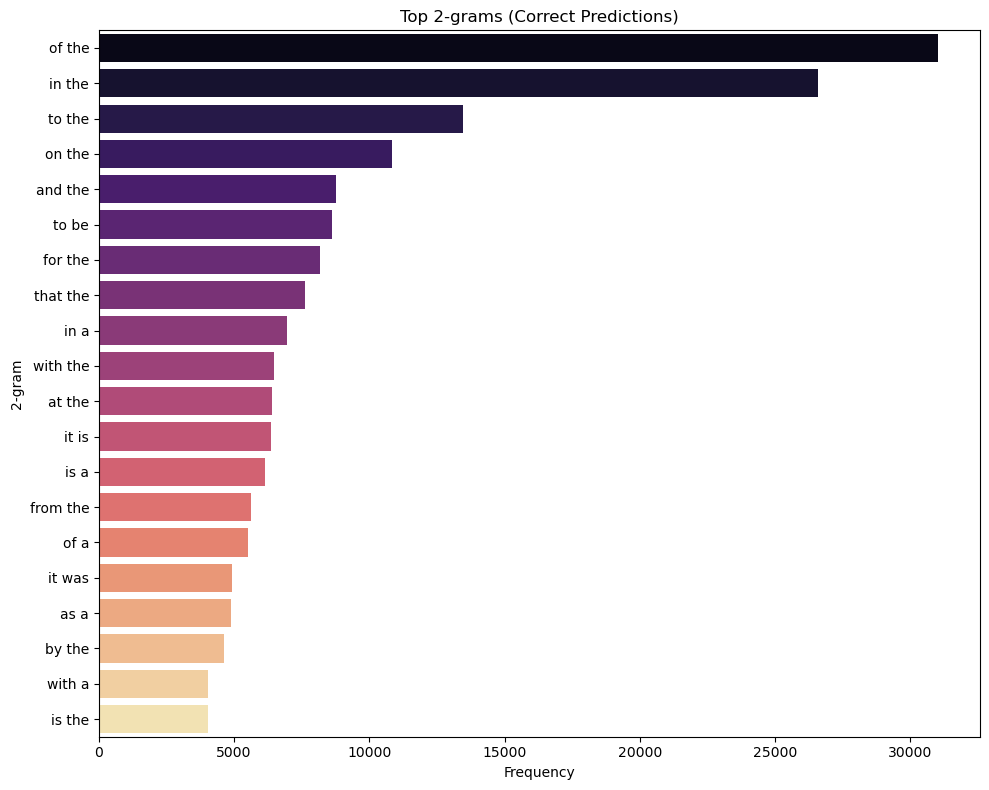


Top 2-grams for Incorrect Predictions:
      2-gram  Frequency
0     of the      12424
1     in the       9469
2     to the       5039
3     on the       3618
4    and the       2949
5    for the       2729
6      to be       2670
7   that the       2573
8      it is       2534
9   with the       2195
10  from the       2022
11      is a       1956
12      in a       1949
13    by the       1920
14    at the       1900
15      as a       1746
16      of a       1702
17   will be       1514
18    is the       1446
19    it was       1368


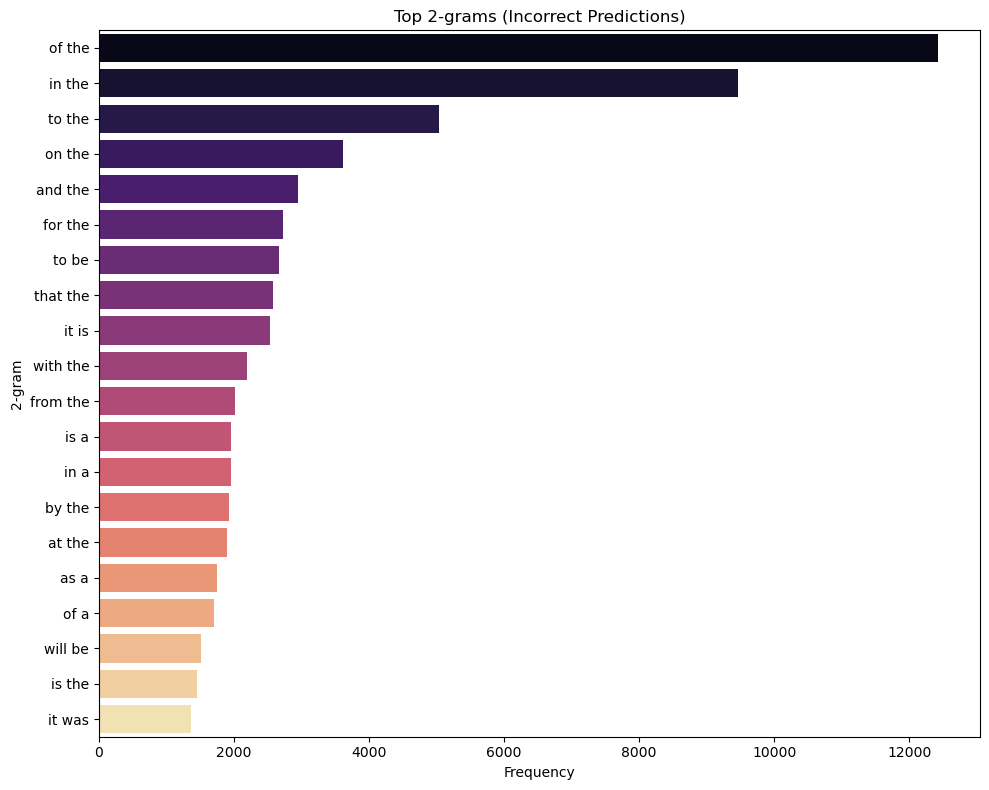


-- Top 3-grams --

Top 3-grams for Correct Predictions:
               3-gram  Frequency
0          one of the       2339
1            a lot of       2100
2   the united states       1919
3          as well as       1492
4          be able to       1291
5         in order to       1111
6         some of the       1031
7       the fact that       1011
8    according to the       1009
9             to be a        929
10        a number of        868
11      the number of        810
12        part of the        796
13        you want to        754
14          this is a        729
15        going to be        729
16         there is a        708
17         the end of        706
18         out of the        692
19      in the united        679


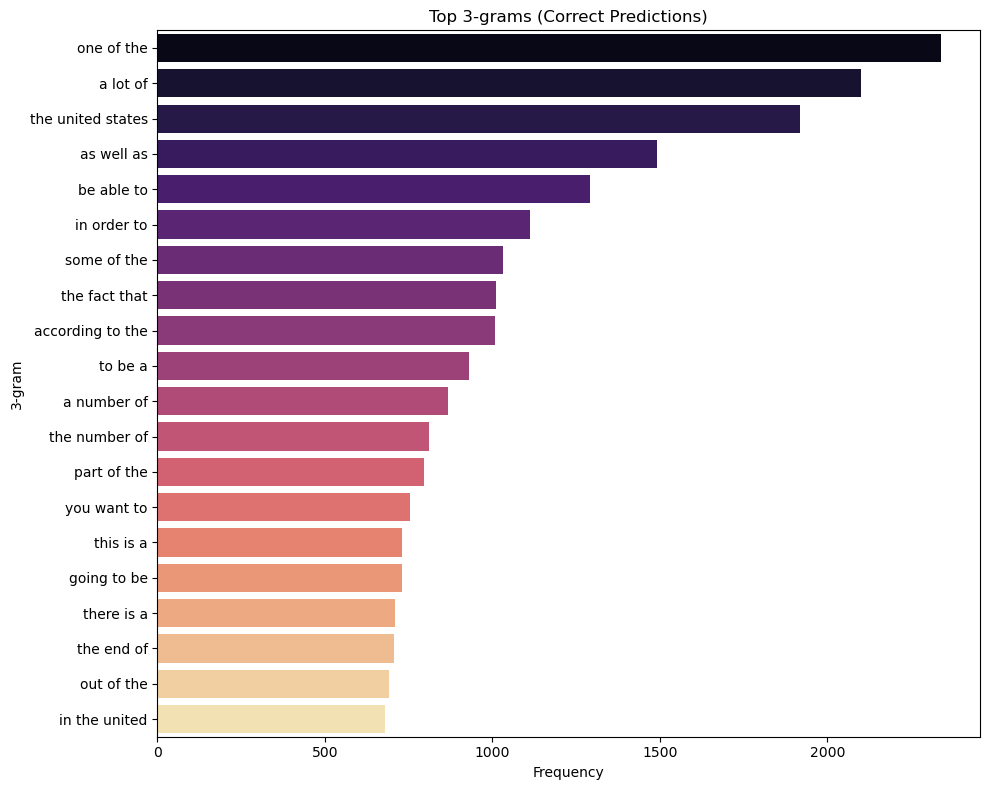


Top 3-grams for Incorrect Predictions:
               3-gram  Frequency
0          one of the        849
1          as well as        589
2         in order to        482
3   the united states        481
4       the fact that        419
5            a lot of        417
6          the use of        322
7          be able to        318
8    according to the        318
9         some of the        317
10         there is a        287
11        as a result        261
12        a number of        259
13        part of the        258
14       in the world        246
15         the end of        240
16      the number of        231
17       on the other        222
18        in terms of        217
19          is one of        217


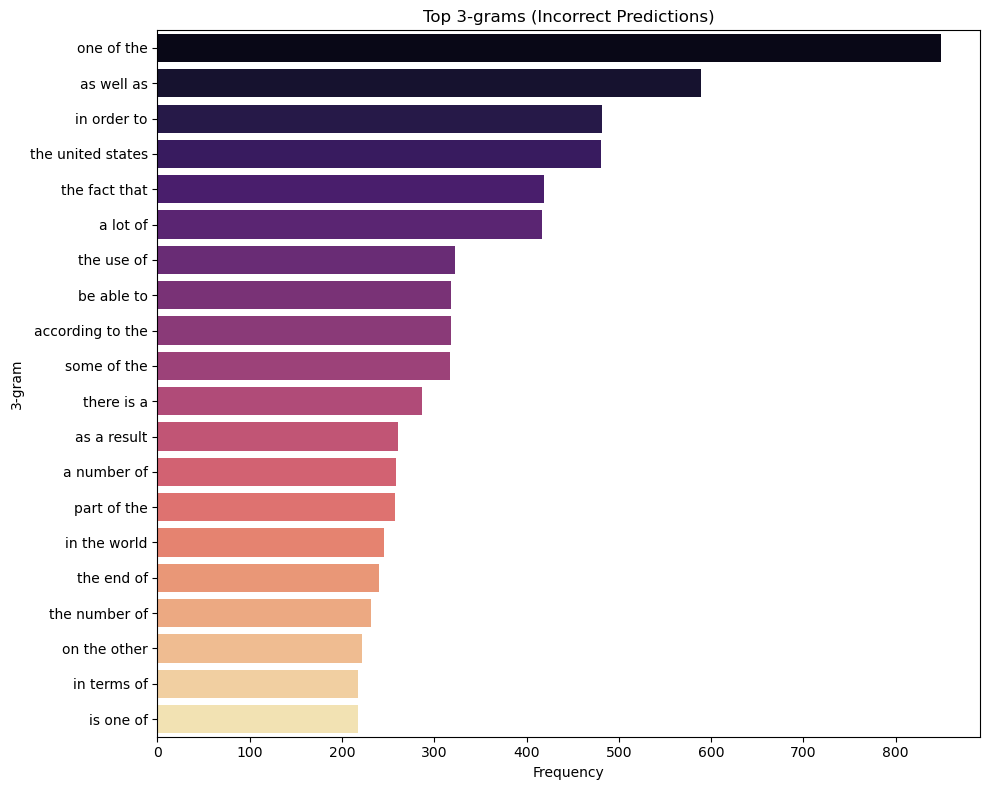

In [16]:
## 4 N-gram Analysis
print("\n--- Analyzing N-grams ---")

def get_top_ngrams(text_series, n=2, num_ngrams=20):
    if len(text_series) == 0:
        return pd.DataFrame(columns=[f'{n}-gram', 'Frequency'])

    # Simple whitespace and punctuation cleaning for n-grams
    def clean_for_ngrams(text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip() # Normalize whitespace
        return text

    all_ngrams = []
    cleaned_texts = text_series.apply(clean_for_ngrams)
    for text in cleaned_texts:
        words = text.split()
        if len(words) >= n:
            grams = [" ".join(words[i:i+n]) for i in range(len(words) - n + 1)]
            all_ngrams.extend(grams)

    if not all_ngrams:
        return pd.DataFrame(columns=[f'{n}-gram', 'Frequency'])

    ngram_freq = Counter(all_ngrams)
    common_ngrams = ngram_freq.most_common(num_ngrams)
    return pd.DataFrame(common_ngrams, columns=[f'{n}-gram', 'Frequency'])

def plot_ngrams(df, title, filename):
    if df.empty:
        print(f"Skipping plot for '{title}': No n-grams found.")
        return
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, filename))
    plt.show()


# Analyze Bigrams (n=2) and Trigrams (n=3)
for n_gram_size in [2, 3]:
    print(f"\n-- Top {n_gram_size}-grams --")

    # Correct
    top_ngrams_correct = get_top_ngrams(correct_df['text'], n=n_gram_size, num_ngrams=20)
    print(f"\nTop {n_gram_size}-grams for Correct Predictions:")
    print(top_ngrams_correct)
    plot_ngrams(top_ngrams_correct, f'Top {n_gram_size}-grams (Correct Predictions)', f"ngram{n_gram_size}_correct.png")

    # Incorrect
    top_ngrams_incorrect = get_top_ngrams(incorrect_df['text'], n=n_gram_size, num_ngrams=20)
    print(f"\nTop {n_gram_size}-grams for Incorrect Predictions:")
    print(top_ngrams_incorrect)
    plot_ngrams(top_ngrams_incorrect, f'Top {n_gram_size}-grams (Incorrect Predictions)', f"ngram{n_gram_size}_incorrect.png")

    # FP / FN
    # top_ngrams_fp = get_top_ngrams(fp_df['text'], n=n_gram_size, num_ngrams=15)
    # plot_ngrams(top_ngrams_fp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_fp.png")
    # top_ngrams_fn = get_top_ngrams(fn_df['text'], n=n_gram_size, num_ngrams=15)
    # plot_ngrams(top_ngrams_fn, f'Top {n_gram_size}-grams (False Negatives)', f"ngram{n_gram_size}_fn.png")

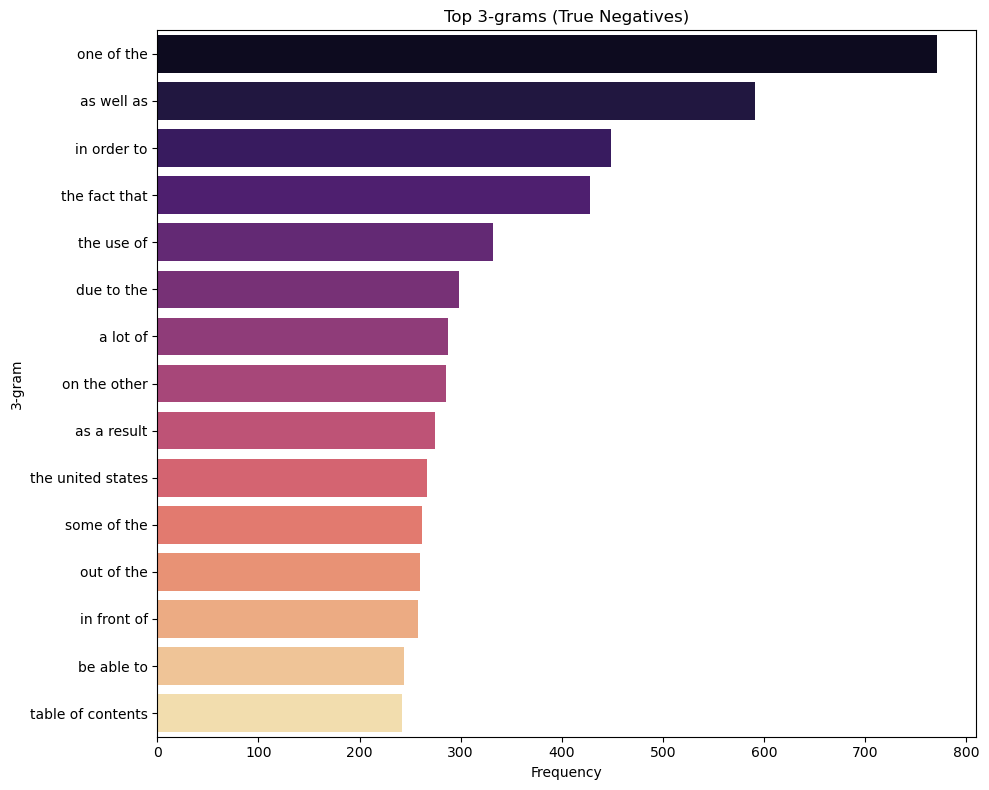

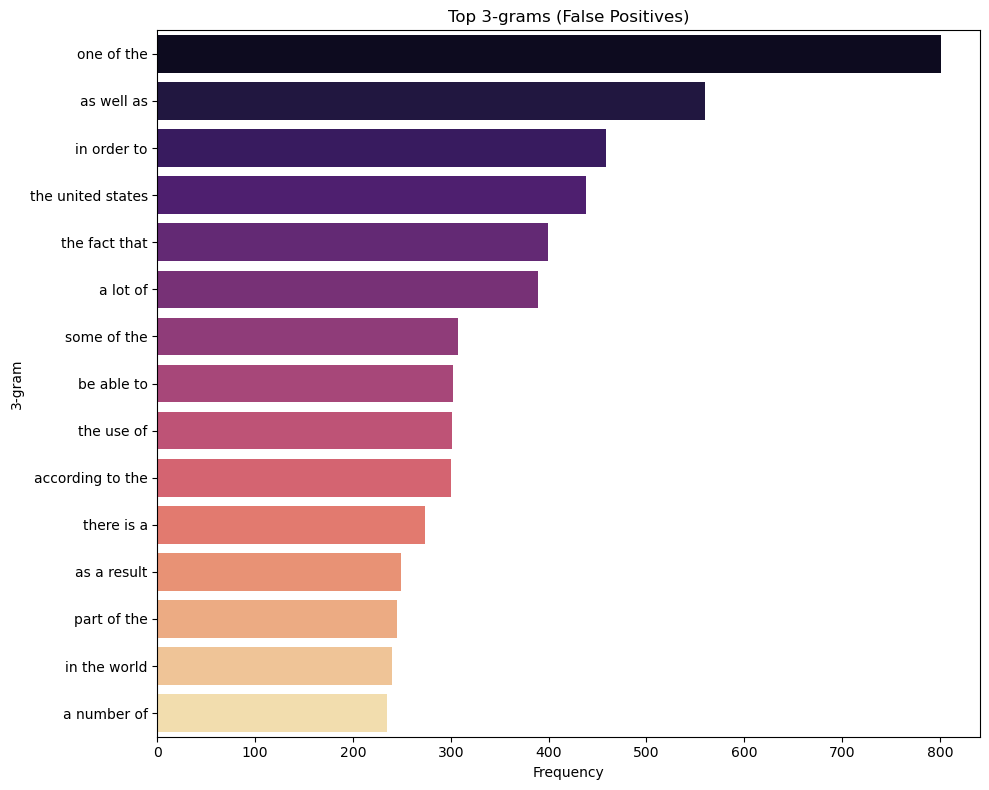

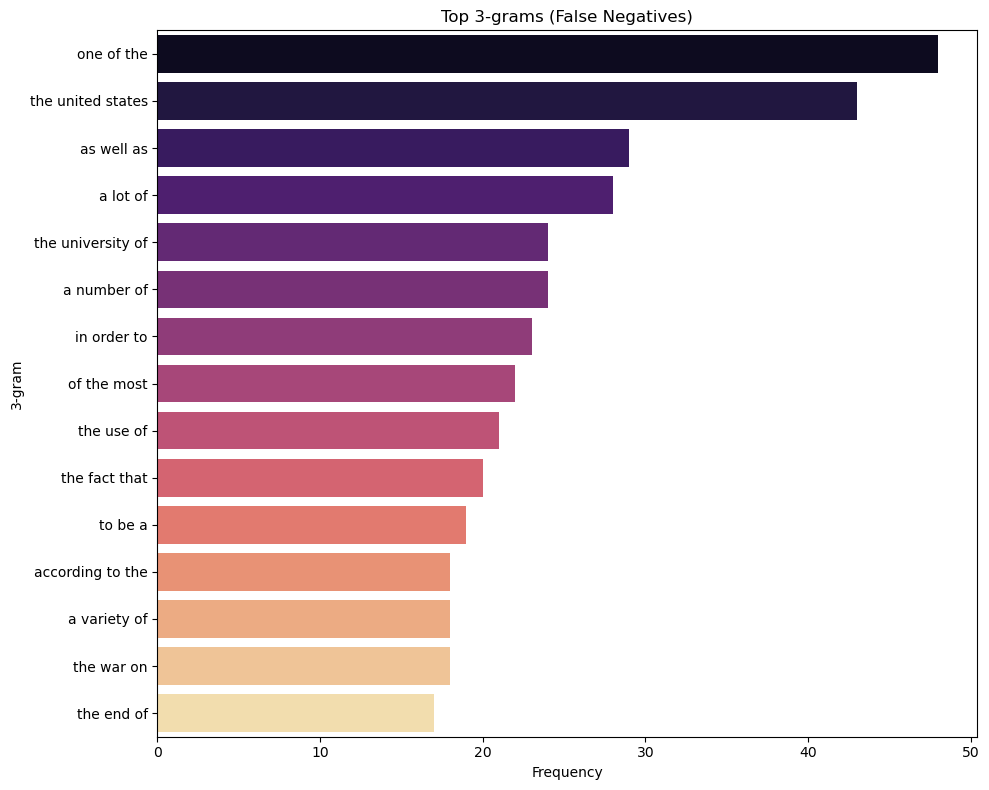

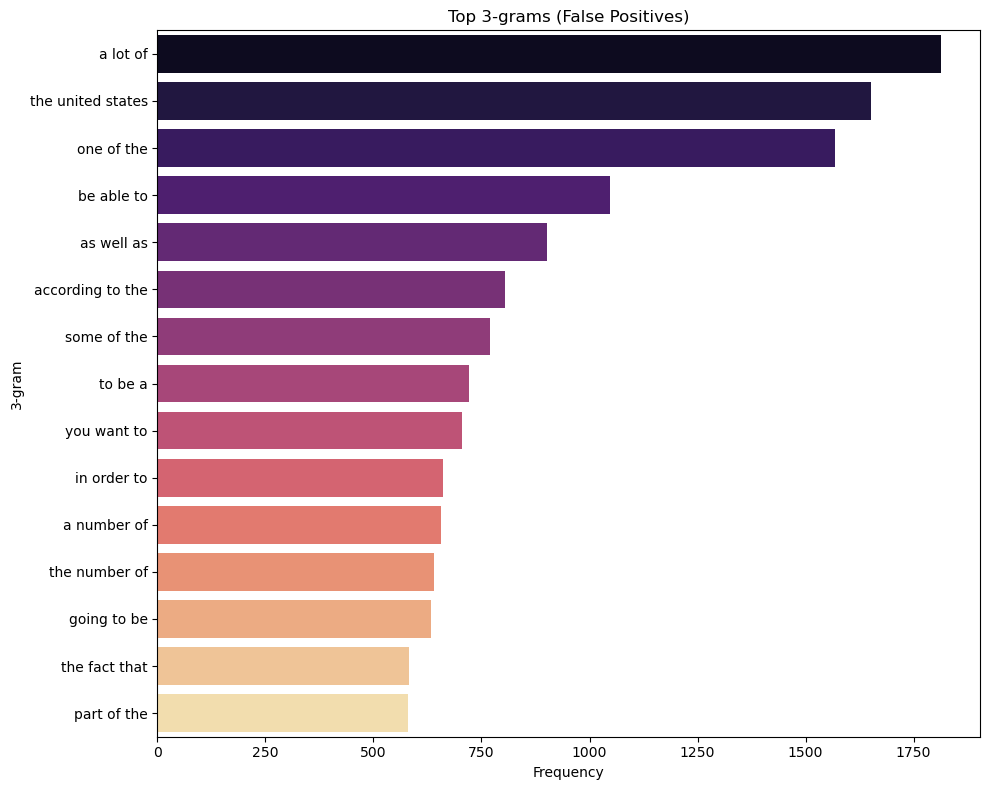

In [17]:
top_ngrams_tn = get_top_ngrams(tn_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_tn, f'Top {n_gram_size}-grams (True Negatives)', f"ngram{n_gram_size}_tn.png")
top_ngrams_fp = get_top_ngrams(fp_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_fp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_fp.png")
top_ngrams_fn = get_top_ngrams(fn_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_fn, f'Top {n_gram_size}-grams (False Negatives)', f"ngram{n_gram_size}_fn.png")
top_ngrams_tp = get_top_ngrams(tp_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_tp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_tp.png")

- FP Root Cause (Topic Bias): The model seems biased towards flagging text about news, reporting, information dissemination, and certain common AI-generated topics (like games) as AI-generated, even when written by humans. These human texts (FPs) might lack the typical personal/work narrative keywords found strongly in TNs.

- FN Root Cause (Jargon/Mimicry + Simplicity): The model fails to detect AI when the text uses specialized jargon outside the model's core "AI keyword profile" or when it successfully mimics human interaction patterns (support, casual chat), especially when combined with simpler sentence structures (lower complexity scores).

- Model's AI Profile: The model associates AI (TP) with common words, reporting (said), specific topics (game, government), and expressions of intent/information (want, think, need).

- This complete picture strongly suggests the model uses a combination of topical cues and structural complexity, but it can be misled when these signals conflict or when encountering text outside its typical training distribution patterns (niche human topics flagged as AI, niche AI topics/styles flagged as human).




--- Analyzing Prediction Confidence ---


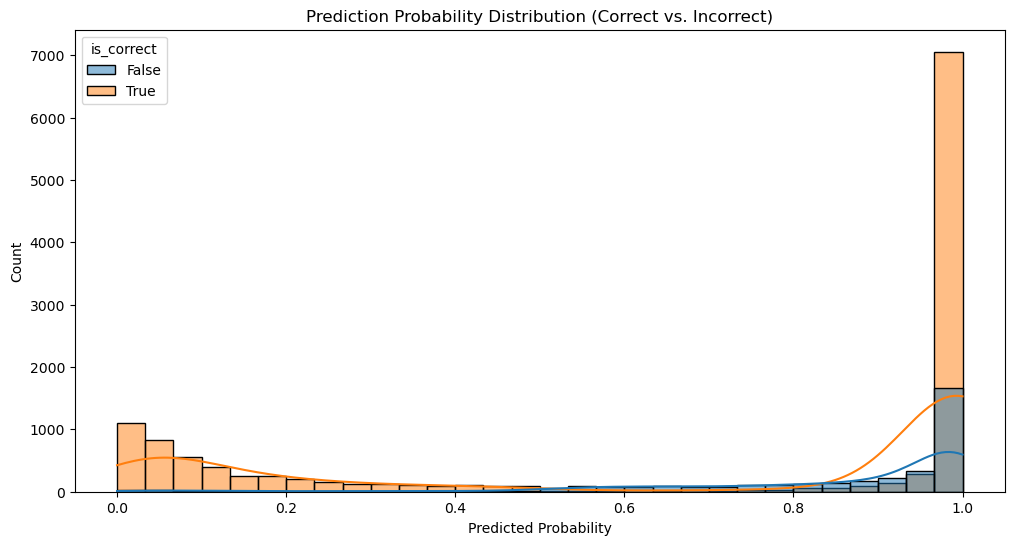


Average Prediction Probability:
is_correct
False    0.855082
True     0.671908
Name: pred_probability, dtype: float32


In [18]:
## 5 Confidence Analysis 
print("\n--- Analyzing Prediction Confidence ---")
plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='pred_probability', hue='is_correct', kde=True, bins=30)
plt.title('Prediction Probability Distribution (Correct vs. Incorrect)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.savefig(os.path.join(OUTPUT_DIR, "confidence_histogram.png"))
plt.show()

print("\nAverage Prediction Probability:")
print(val_df.groupby('is_correct')['pred_probability'].mean())

**Implications:**
- Overconfidence in Errors: This suggests the model might be latching onto certain features or patterns that strongly (but incorrectly) indicate one class over the other in specific cases.

- Calibration: The model might be poorly calibrated, meaning its predicted probabilities don't accurately reflect the true likelihood of correctness. Ideally, predictions made with ~80% confidence should be correct about 80% of the time, which isn't happening for the incorrect group.

- Difficulty of Errors: The errors the model makes aren't necessarily "borderline" cases from its perspective. It often makes a mistake with conviction.


--- Analyzing Prediction Confidence by result type ---


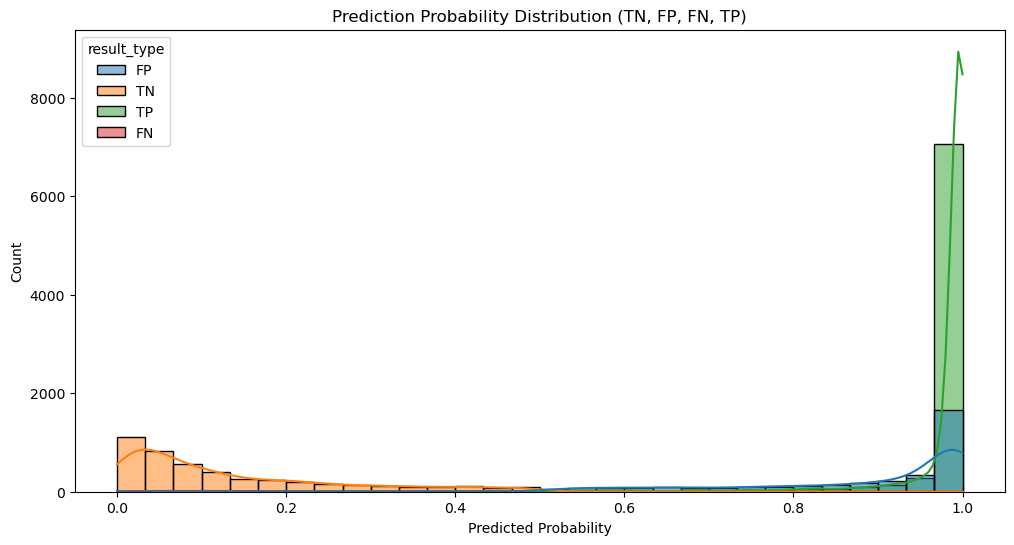


Average Prediction Probability:
result_type
FN    0.227546
FP    0.891455
TN    0.131179
TP    0.980680
Name: pred_probability, dtype: float32


In [19]:
print("\n--- Analyzing Prediction Confidence by result type ---")
plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='pred_probability', hue='result_type', kde=True, bins=30)
plt.title('Prediction Probability Distribution (TN, FP, FN, TP)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.savefig(os.path.join(OUTPUT_DIR, "confidence_histogram_by_type.png"))
plt.show()

print("\nAverage Prediction Probability:")
print(val_df.groupby('result_type')['pred_probability'].mean())

In [20]:
# --- 5.1 Analysis of High-Confidence Errors ---
print("\n--- Analyzing High-Confidence Errors ---")

# Define the confidence threshold
confidence_threshold = 0.90 

text_col = 'text'
true_label_col = 'label' 
pred_label_col = 'prediction' 
prob_col = 'pred_probability' 
correct_col = 'is_correct'

# Filter for incorrect predictions with high confidence
high_confidence_errors_df = val_df[
    (val_df[correct_col] == False) &
    (val_df[prob_col] > confidence_threshold)
].copy() 

# Sort by probability to see the most confident errors first
high_confidence_errors_df = high_confidence_errors_df.sort_values(by=prob_col, ascending=False)

print(f"Found {len(high_confidence_errors_df)} examples where the prediction was incorrect")
print(f"but the model's confidence in the wrong prediction was > {confidence_threshold:.2f}")

# --- Displaying Examples ---

# Display the top N most confident errors
num_examples_to_show = 10 

print(f"\n--- Top {num_examples_to_show} Most Confident Errors ---")

if len(high_confidence_errors_df) > 0:
    display_cols = [text_col, true_label_col, pred_label_col, prob_col]
    
    display_cols = [col for col in display_cols if col in high_confidence_errors_df.columns]

    for index, row in high_confidence_errors_df.head(num_examples_to_show).iterrows():
        print(f"\n--- Example Index: {index} ---")
        print(f"  True Label:       {row[true_label_col]}")
        print(f"  Predicted Label:  {row[pred_label_col]}")
        print(f"  Confidence (Wrong): {row[prob_col]:.4f}")
        # Print the first 500 characters of the text for brevity
        print(f"  Text Snippet:     {row[text_col][:500]}...") 
        print("-" * 30)
else:
    print("No high-confidence errors found matching the criteria.")

# --- Saving Examples ---

if len(high_confidence_errors_df) > 0 and 'OUTPUT_DIR' in locals():
    try:
        output_filename = os.path.join(OUTPUT_DIR, f"high_confidence_errors_gt_{confidence_threshold:.2f}.csv")
        # Save to a CSV
        high_confidence_errors_df.to_csv(output_filename, index=False)
        print(f"\nSaved all {len(high_confidence_errors_df)} high-confidence error examples to: {output_filename}")
    except Exception as e:
        print(f"\nCould not save high-confidence errors to CSV: {e}")



--- Analyzing High-Confidence Errors ---
Found 2222 examples where the prediction was incorrect
but the model's confidence in the wrong prediction was > 0.90

--- Top 10 Most Confident Errors ---

--- Example Index: 3759 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 0.9997
  Text Snippet:     translation for the fat bag by samanta maragno if you make this bag from yarn and an h hook the bag comes out about inches high inches across at the widest point thats a bit small for me so the tan bag shown in the pattern i made by adding rows to each end and rows across the middle its about inches high and about inches across at the widest point i also made another bag by using strands of yarn held together and a k hook by following the pattern not adding any rows it came out about the same la...
------------------------------

--- Example Index: 11009 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 0.9997
  Text Snippet:     germany economic situat

In [21]:
# ## 6 Word Clouds (Visual Keyword Summary)
# print("\n--- Generating Word Clouds ---")

# def generate_wordcloud(text_series, title, filename):
#     if len(text_series) == 0 or text_series.str.len().sum() == 0:
#         print(f"Skipping word cloud for '{title}': No text data.")
#         return

#     text = ' '.join(text_series.astype(str))
#     wordcloud = WordCloud(
#         stopwords=stop_words,
#         background_color='white',
#         max_words=100,
#         width=800, height=400
#         # max_font_size=50,
#         # scale=2,
#         # random_state=42
#     ).generate(text)

#     plt.figure(figsize=(12, 6))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(title)
#     plt.savefig(os.path.join(OUTPUT_DIR, filename))
#     plt.show()

# generate_wordcloud(correct_df['text'], 'Word Cloud (Correct Predictions)', 'wordcloud_correct.png')
# generate_wordcloud(incorrect_df['text'], 'Word Cloud (Incorrect Predictions)', 'wordcloud_incorrect.png')
# # generate_wordcloud(fp_df['text'], 'Word Cloud (False Positives)', 'wordcloud_fp.png')
# # generate_wordcloud(fn_df['text'], 'Word Cloud (False Negatives)', 'wordcloud_fn.png')